# LSTM Introductory Quantitative Strategy - Victor Bustos & Marcus Victor

Based on LSTM stock prediction values, we calculate 7-days futures returns, analysing SP&500 stocks and selecting the desired stocks to add to the portfolio through a 'low-volatility-momentum' strategy. We further analyze the momentum scores of the stocks using three different periods (1-month, 3-month and 6-month momentum scores), selecting a reasonable momentum threshold in accordance to the distributions of these scores. We set a maximum volatility by using a 63 days volatility window, calculating all volatilities fitting this criteria and afterwards averaging them out to a single value, for each stock. We select the stocks to be invested based upon these two criterias, attributing weights to the stocks in a decile basis: the top 10% gets bigger weights ('winners' portfolio), going down until the last 10%, with smaller weights ('losers' portfolio).

* A momentum strategy is a strategy to buy past winners and to sell
past losers. It's a bet on the ability of past returns to predict future returns - academic literature has documented evidence that momentum profits are significantly positive and pervasive across multiple time periods.

Load Data

In [1]:
from modules.load_data import load_data
import numpy as np
dict_data = load_data()

* Initial Exploratory Analysis

Stock selection process: target function to be optimized was thought out to be a weighted mean between the three momentum periods, using volatility threshold to exclude some of the stocks. Momentum threshold determined after looking at the momentum histograms - later, it may be altered.

In [45]:
log_returns = np.log(dict_data['prices']).diff().fillna(0)
returns = (dict_data['prices'].diff()/dict_data['prices'].shift(1)).fillna(0)
log_returns

Ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-03,-0.015713,-0.024751,-0.012395,-0.007648,0.000000,-0.010080,-0.030210,-0.003130,-0.005329,-0.017774,...,-0.032185,-0.001788,-0.020174,-0.004982,0.000000,-0.001293,-0.007725,-0.023279,-0.007523,0.000000
2011-06-06,-0.007787,-0.038934,-0.014782,-0.015474,0.000000,0.002678,-0.024606,-0.001569,-0.004462,-0.000673,...,0.000735,-0.010995,-0.011419,-0.024152,0.000000,-0.009750,-0.010742,-0.012576,-0.032340,0.000000
2011-06-07,0.013588,0.001240,-0.007849,-0.017700,0.000000,0.011229,0.014135,0.007299,-0.002687,0.008710,...,0.013134,-0.003625,-0.003244,-0.016624,0.000000,0.004887,-0.009978,0.003644,-0.016854,0.000000
2011-06-08,0.000642,-0.035313,-0.000375,0.000000,0.000000,0.001468,-0.002342,0.003112,-0.005396,-0.009383,...,-0.024955,0.009437,-0.000887,-0.015143,0.000000,-0.010783,-0.016139,-0.000728,0.010707,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,-0.008848,0.011009,0.024369,-0.007582,-0.007162,0.000479,0.000000,0.004248,-0.016571,-0.003424,...,0.000000,0.018289,0.022461,0.005002,-0.003248,-0.010155,-0.008229,0.032676,0.017884,-0.004942
2023-06-27,-0.011321,0.053875,0.015191,0.014947,-0.017567,0.005418,0.000000,-0.006657,-0.001124,0.011367,...,0.000000,0.002490,0.015202,0.013452,0.008458,0.000372,0.013907,0.034901,0.008091,0.018510
2023-06-28,-0.005752,0.011461,-0.003519,0.006308,-0.000679,0.004967,0.000000,-0.001671,0.007562,0.003021,...,0.000000,0.008097,-0.008332,-0.013452,-0.009633,0.006532,-0.005609,0.002402,-0.007722,-0.009242


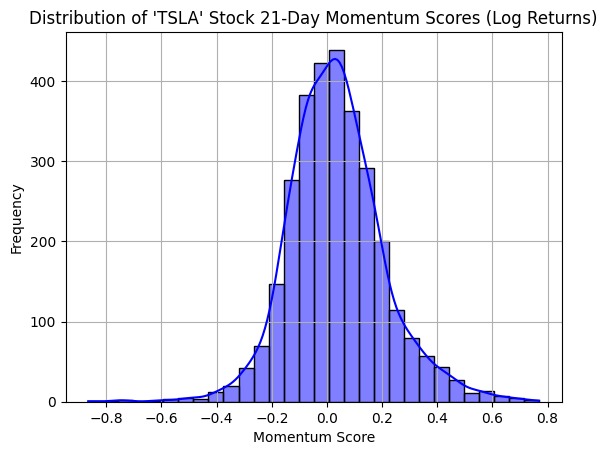

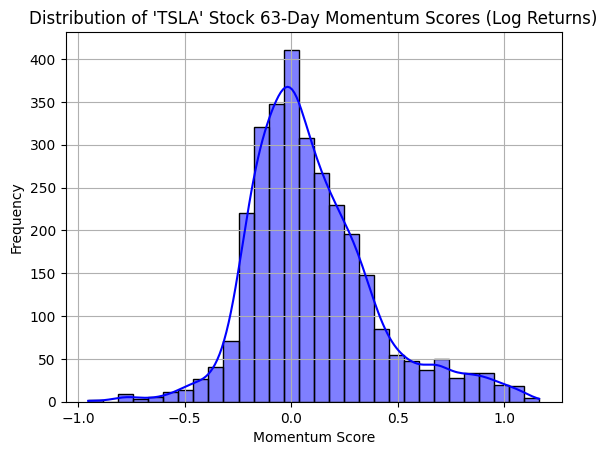

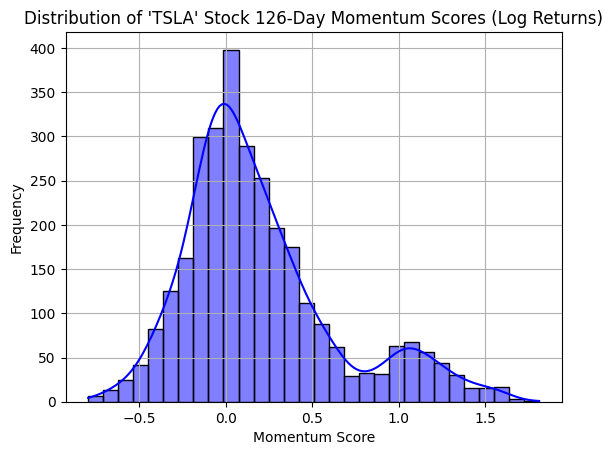

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

volatility_window = 63  # Assuming daily data

# Initialize an empty DataFrame to store momentum scores of each analyzed period, and volatility within the 63-day period:
momentum_scores_df = pd.DataFrame(index=log_returns.index)
momentum_scores_21 = pd.DataFrame(index=log_returns.index)
momentum_scores_63 = pd.DataFrame(index=log_returns.index)
momentum_scores_126 = pd.DataFrame(index=log_returns.index)
vol_df = pd.DataFrame(index=log_returns.index)
volatilities = []
for column in log_returns:
    # Calculate the rolling standard deviation to measure mean volatility for this stock
    vol_df[f'{volatility_window}-Day Low Volatility of {column} Stock'] = np.nan_to_num(log_returns[column].rolling(volatility_window).std())
    vol_values = np.nan_to_num(log_returns[column].rolling(volatility_window).std().values)
    mean_vol = np.mean(vol_values)
    volatilities.append(mean_vol)

    # Define multiple momentum periods in terms of trading days
    momentum_periods = [21, 63, 126]  # 1-month, 3-month, and 6-month

    # Calculate momentum scores for each period and store in the DataFrame
    for period in momentum_periods:
        momentum_scores = log_returns[column].rolling(period).sum()
        momentum_scores = momentum_scores.shift(-period)
        momentum_scores_df[f'{period}-Day Momentum of {column} Stock'] = np.nan_to_num(momentum_scores)

momentum_scores_df.fillna(0)
vol_df.fillna(0)
column = 'TSLA'
for period in momentum_periods:
    plt.figure()
    sns.histplot(momentum_scores_df[f'{period}-Day Momentum of {column} Stock'], bins=30, kde=True, color='blue', edgecolor='k')
    plt.title(f"Distribution of '{column}' Stock {period}-Day Momentum Scores (Log Returns)")
    plt.xlabel('Momentum Score')
    plt.ylabel('Frequency')
    plt.grid(True)

# Define thresholds for low volatility and momentum based on volatilities array and momentum_scores_df
low_volatility_threshold = 0.02
momentum_threshold = np.log(1.1) # 110% momentum score, in an attempt to guarantee nice stock volume with good upward prospect trend.

# Create boolean DataFrames for low volatility and momentum
low_volatility_condition = vol_df < low_volatility_threshold
momentum_condition = momentum_scores_df > momentum_threshold

# Combine the conditions to select assets
selected_assets_df = low_volatility_condition & momentum_condition

for column in selected_assets_df:
   if selected_assets_df[column].rolling(low_volatility_period).fillna(0) != 0:
       sel_stocks.append(column)

In [48]:
np.max(volatilities)

0.04608641287225426

In [7]:
momentum_scores_df

,21-Day Momentum of A Stock,63-Day Momentum of A Stock,126-Day Momentum of A Stock,21-Day Momentum of AAL Stock,63-Day Momentum of AAL Stock,126-Day Momentum of AAL Stock,21-Day Momentum of AAP Stock,63-Day Momentum of AAP Stock,126-Day Momentum of AAP Stock,21-Day Momentum of AAPL Stock,...,126-Day Momentum of ZBH Stock,21-Day Momentum of ZBRA Stock,63-Day Momentum of ZBRA Stock,126-Day Momentum of ZBRA Stock,21-Day Momentum of ZION Stock,63-Day Momentum of ZION Stock,126-Day Momentum of ZION Stock,21-Day Momentum of ZTS Stock,63-Day Momentum of ZTS Stock,126-Day Momentum of ZTS Stock
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-02,0.076242,-0.267628,-0.250724,-0.018802,-0.488568,-0.657695,-0.022535,0.004519,0.136448,-0.007648,...,-0.271624,0.006553,-0.170047,-0.117724,0.057218,-0.278446,-0.358665,0.0,0.0,0.0
2011-06-03,0.085448,-0.280169,-0.226462,-0.051419,-0.518412,-0.586832,-0.021694,0.010401,0.142024,0.018070,...,-0.257860,0.025390,-0.168716,-0.093917,0.051509,-0.316500,-0.362703,0.0,0.0,0.0
2011-06-06,0.096494,-0.313418,-0.247043,-0.025127,-0.493605,-0.569591,-0.012362,0.010370,0.161411,0.040120,...,-0.286000,0.045435,-0.196488,-0.091424,0.081798,-0.313452,-0.311168,0.0,0.0,0.0
2011-06-07,0.093497,-0.340917,-0.252325,-0.020026,-0.530009,-0.513307,0.019508,0.024464,0.181540,0.072690,...,-0.261977,0.042954,-0.216257,-0.083139,0.116460,-0.308868,-0.256264,0.0,0.0,0.0
2011-06-08,0.051020,-0.290899,-0.255037,-0.006439,-0.461567,-0.453453,0.013238,0.043701,0.184415,0.080043,...,-0.244239,0.049933,-0.188797,-0.085579,0.103228,-0.262589,-0.298201,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = dict_data['prices']
df = df[['A', 'DXCM', 'TSLA', 'AAPL', 'MSFT']]
log_df = np.log(df).diff().fillna(0)
log_df

Ticker,A,DXCM,TSLA,AAPL,MSFT
Date,,,,,
2011-06-02,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-03,-0.015713,-0.027029,0.045810,-0.007648,-0.012672
2011-06-06,-0.007787,-0.036266,-0.051031,-0.015474,0.004242
2011-06-07,0.013588,0.000000,-0.010526,-0.017700,0.002114
2011-06-08,0.000642,-0.011429,-0.043250,0.000000,-0.005294
...,...,...,...,...,...
2023-06-26,-0.008848,-0.016948,-0.062514,-0.007582,-0.019349
2023-06-27,-0.011321,-0.009028,0.037296,0.014947,0.018005
2023-06-28,-0.005752,0.023369,0.023814,0.006308,0.003819


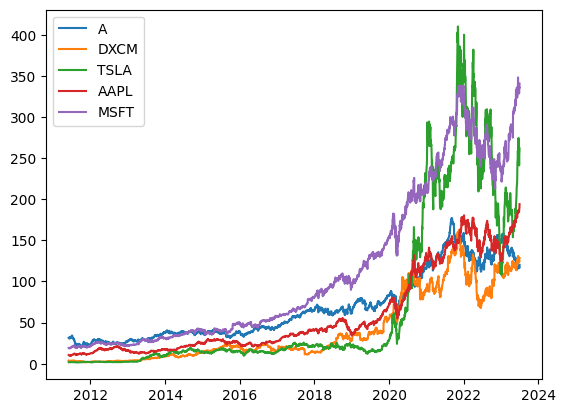

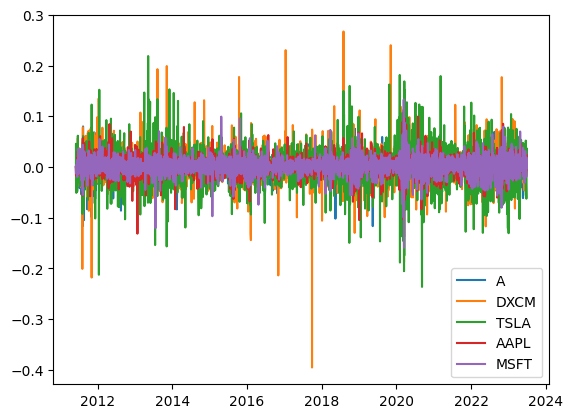

In [9]:
plt.figure(1)
plt.plot(df.index, df['A'])
plt.plot(df.index, df['DXCM'], df['TSLA'])
plt.plot(df.index, df['AAPL'], df['MSFT'])
plt.legend(['A', 'DXCM', 'TSLA', 'AAPL', 'MSFT'])

plt.figure(2)
plt.plot(log_df.index, log_df['A'])
plt.plot(log_df.index, log_df['DXCM'], log_df['TSLA'])
plt.plot(log_df.index, log_df['AAPL'], log_df['MSFT'])
plt.legend(['A', 'DXCM', 'TSLA', 'AAPL', 'MSFT'])

In [14]:
log_df.loc['2017-12-29']

Ticker
A      -0.004811
DXCM    0.001395
TSLA   -0.012446
AAPL   -0.010910
MSFT   -0.002119
Name: 2017-12-29 00:00:00, dtype: float64

* Price prediction:

In [15]:
import datetime
import pandas as pd

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  col_name = list(dataframe.columns)[0]
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset[col_name].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target of Stock'] = Y

  return ret_df


# Start day second time around: '2021-03-25'
stocks = list(df.columns)
num_of_past_dates = 60
windowed_df_1 = df_to_windowed_df(log_df[['A']],
                                '2017-12-29',
                                '2019-06-28',
                                n=num_of_past_dates)

windowed_df_2 = df_to_windowed_df(log_df[['DXCM']],
                                '2017-12-29',
                                '2019-06-28',
                                n=num_of_past_dates)

windowed_df_3 = df_to_windowed_df(log_df[['TSLA']],
                                '2017-12-29',
                                '2019-06-28',
                                n=num_of_past_dates)

windowed_df_4 = df_to_windowed_df(log_df[['AAPL']],
                                '2017-12-29',
                                '2019-06-28',
                                n=num_of_past_dates)
                              
windowed_df_5 = df_to_windowed_df(log_df[['MSFT']],
                                '2017-12-29',
                                '2019-06-28',
                                n=num_of_past_dates)

In [16]:
windowed_df_1

,Target Date,Target-60,Target-59,Target-58,Target-57,Target-56,Target-55,Target-54,Target-53,Target-52,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target of Stock
0,2017-12-29,0.010364,-0.001905,0.009963,0.002985,0.000627,0.000314,0.013699,-0.008228,-0.001092,...,0.016506,0.000772,0.001234,-0.005099,0.001703,-0.002478,-0.001552,0.000776,0.002170,-0.004811
1,2018-01-02,-0.001905,0.009963,0.002985,0.000627,0.000314,0.013699,-0.008228,-0.001092,-0.011931,...,0.000772,0.001234,-0.005099,0.001703,-0.002478,-0.001552,0.000776,0.002170,-0.004811,0.009291
2,2018-01-03,0.009963,0.002985,0.000627,0.000314,0.013699,-0.008228,-0.001092,-0.011931,0.004884,...,0.001234,-0.005099,0.001703,-0.002478,-0.001552,0.000776,0.002170,-0.004811,0.009291,0.025114
3,2018-01-04,0.002985,0.000627,0.000314,0.013699,-0.008228,-0.001092,-0.011931,0.004884,0.006579,...,-0.005099,0.001703,-0.002478,-0.001552,0.000776,0.002170,-0.004811,0.009291,0.025114,-0.007544
4,2018-01-05,0.000627,0.000314,0.013699,-0.008228,-0.001092,-0.011931,0.004884,0.006579,0.005450,...,0.001703,-0.002478,-0.001552,0.000776,0.002170,-0.004811,0.009291,0.025114,-0.007544,0.015926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2019-06-24,0.008846,0.008512,0.016557,-0.005192,0.009855,-0.013671,0.007871,0.002778,-0.003284,...,-0.002789,0.002789,0.000147,-0.004700,0.004554,0.022750,0.010262,0.009175,0.000281,-0.002672
372,2019-06-25,0.008512,0.016557,-0.005192,0.009855,-0.013671,0.007871,0.002778,-0.003284,0.003158,...,0.002789,0.000147,-0.004700,0.004554,0.022750,0.010262,0.009175,0.000281,-0.002672,-0.008629
373,2019-06-26,0.016557,-0.005192,0.009855,-0.013671,0.007871,0.002778,-0.003284,0.003158,-0.007342,...,0.000147,-0.004700,0.004554,0.022750,0.010262,0.009175,0.000281,-0.002672,-0.008629,-0.005127
374,2019-06-27,-0.005192,0.009855,-0.013671,0.007871,0.002778,-0.003284,0.003158,-0.007342,-0.001271,...,-0.004700,0.004554,0.022750,0.010262,0.009175,0.000281,-0.002672,-0.008629,-0.005127,0.014460


In [17]:
maxes = [windowed_df_1.drop(columns=['Target Date', 'Target of Stock']).max().max(), windowed_df_2.drop(columns=['Target Date', 'Target of Stock']).max().max(), windowed_df_3.drop(columns=['Target Date', 'Target of Stock']).max().max(), windowed_df_4.drop(columns=['Target Date', 'Target of Stock']).max().max(), windowed_df_5.drop(columns=['Target Date', 'Target of Stock']).max().max()]
max_scale = np.max(maxes)
max_scale

0.26725267710947564

In [18]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X1, y1 = windowed_df_to_date_X_y(windowed_df_1)
_, X2, y2 = windowed_df_to_date_X_y(windowed_df_2)
_, X3, y3 = windowed_df_to_date_X_y(windowed_df_3)
_, X4, y4 = windowed_df_to_date_X_y(windowed_df_4)
_, X5, y5 = windowed_df_to_date_X_y(windowed_df_5)

dates.shape, X2.shape, y2.shape

((376,), (376, 60, 1), (376,))

In [19]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X1_train, y1_train = dates[:q_80], X1[:q_80], y1[:q_80]
dates_val, X1_val, y1_val = dates[q_80:q_90], X1[q_80:q_90], y1[q_80:q_90]
dates_test, X1_test, y1_test = dates[q_90:], X1[q_90:], y1[q_90:]

X2_train, y2_train = X2[:q_80], y2[:q_80]
X2_val, y2_val = X2[q_80:q_90], y2[q_80:q_90]
X2_test, y2_test = X2[q_90:], y2[q_90:]

X3_train, y3_train = X3[:q_80], y3[:q_80]
X3_val, y3_val = X3[q_80:q_90], y3[q_80:q_90]
X3_test, y3_test = X3[q_90:], y3[q_90:]

X4_train, y4_train = X4[:q_80], y4[:q_80]
X4_val, y4_val = X4[q_80:q_90], y4[q_80:q_90]
X4_test, y4_test = X4[q_90:], y4[q_90:]

X5_train, y5_train = X5[:q_80], y5[:q_80]
X5_val, y5_val = X5[q_80:q_90], y5[q_80:q_90]
X5_test, y5_test = X5[q_90:], y5[q_90:]

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train,X5_train),axis=2)
y_train = np.concatenate((y1_train,y2_train,y3_train,y4_train,y5_train))

X_val = np.concatenate((X1_val,X2_val,X3_val,X4_val,X5_val),axis=2)
y_val = np.concatenate((y1_val,y2_val,y3_val,y4_val,y5_val))

X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test,X5_test),axis=2)
y_test = np.concatenate((y1_test,y2_test,y3_test,y4_test,y5_test))

In [20]:
scaled_Xtrain = X_train / max_scale
y1_train = y1_train / max_scale
y2_train = y2_train / max_scale
y3_train = y3_train / max_scale
y4_train = y4_train / max_scale
y5_train = y5_train / max_scale

scaled_Xval = X_val / max_scale
scaled_y1val = y1_val / max_scale

scaled_Xtest = X_test / max_scale
scaled_y1test = y1_test / max_scale
scaled_y2test = y2_test / max_scale
scaled_y3test = y3_test / max_scale
scaled_y4test = y4_test / max_scale
scaled_y5test = y5_test / max_scale
scaled_ytest = y_test / max_scale

In [534]:
# plt.figure()
# plt.plot(dates_train, y1_train)
# plt.plot(dates_val, y1_val)
# plt.plot(dates_test, y1_test)
# plt.legend(['Train', 'Validation', 'Test'])

# plt.figure()
# plt.plot(dates_train, y2_train)
# plt.plot(dates_val, y2_val)
# plt.plot(dates_test, y2_test)
# plt.legend(['Train', 'Validation', 'Test'])

# plt.figure()
# plt.plot(dates_train, y3_train)
# plt.plot(dates_val, y3_val)
# plt.plot(dates_test, y3_test)
# plt.legend(['Train', 'Validation', 'Test'])

# plt.figure()
# plt.plot(dates_train, y4_train)
# plt.plot(dates_val, y4_val)
# plt.plot(dates_test, y4_test)
# plt.legend(['Train', 'Validation', 'Test'])

# plt.figure()
# plt.plot(dates_train, y5_train)
# plt.plot(dates_val, y5_val)
# plt.plot(dates_test, y5_test)
# plt.legend(['Train', 'Validation', 'Test'])

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Parâmetros para experimentação
num_dense_layers_list = [1, 2, 3]  # Número de camadas Dense
num_neurons_list = [4, 8, 16, 32]  # Número de neurônios em cada camada

best_mse = float('inf')  # Melhor MSE inicializado com infinito
best_combination = None  # Melhor combinação de hiperparâmetros inicializada com None

for num_dense_layers in num_dense_layers_list:
    for num_neurons in num_neurons_list:
        print(f"Experimentando com {num_dense_layers} camadas Dense e {num_neurons} neurônios por camada")

        # Crie o modelo
        model = Sequential([layers.Input(shape=(60, 5)),
                            layers.LSTM(96)])
        
        for _ in range(num_dense_layers):
            model.add(layers.Dense(num_neurons, activation=activations.elu))

        model.add(layers.Dense(1))

        # Compile o modelo
        optimizer = Adam(learning_rate=0.0001, epsilon=1e-8)
        model.compile(loss=Huber(delta=1.0), optimizer=optimizer, metrics=['mean_squared_error'])

        # Adicione Early Stopping para evitar overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        # Treine o modelo
        model.fit(scaled_Xtrain, y1_train, validation_data=(scaled_Xval, scaled_y1val), epochs=100, callbacks=[early_stopping])

        # Avalie o modelo
        train_predictions = model.predict(scaled_Xtrain).flatten()
        mse = mean_squared_error(y1_train, train_predictions)
        print("MSE:", mse)
        print("\n")

        # Atualize a melhor combinação se uma combinação melhor for encontrada
        if mse < best_mse:
            best_mse = mse
            best_combination = (num_dense_layers, num_neurons)

Experimentando com 1 camadas Dense e 4 neurônios por camada
Epoch 1/100
10/10 [==============================] - 3s 83ms/step - loss: 0.0020 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0023
Epoch 2/100
10/10 [==============================] - 0s 34ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0023
Epoch 3/100
10/10 [==============================] - 0s 32ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0023
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0023
Epoch 5/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0019 - mean_squared_error: 0.0038 - val_loss: 0.0012 - val_mean_squared_error: 0.0023
Epoch 6/100
10/10 [==============================] - 1s 77ms/step - loss: 0.0019 - mean_squared_error: 0.0038 - val_loss: 0.0011 -

In [27]:
# Imprima a melhor combinação e seu respectivo MSE
print(f"Melhor combinação: {best_combination}")
print(f"Melhor MSE: {best_mse:.8f}")

Melhor combinação: (2, 8)
Melhor MSE: 0.00357754


In [28]:
model = Sequential([layers.Input(shape=(60, 5)),
                    layers.LSTM(96),
                    layers.Dense(8, activation=activations.elu),
                    layers.Dense(8, activation=activations.elu),
                    layers.Dense(1)])

model.compile(loss=Huber(delta=1.0), 
              optimizer=Adam(learning_rate=0.0001, epsilon=1e-8),
              metrics=['mean_squared_error'])

# Adicione Early Stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(scaled_Xtrain, y1_train, validation_data=(scaled_Xval, scaled_y1val), epochs=100, callbacks=[early_stopping])

train_predictions = model.predict(scaled_Xtrain).flatten()
mse = mean_squared_error(y1_train, train_predictions)
print("MSE:", mse)

Epoch 1/100
10/10 [==============================] - 5s 139ms/step - loss: 0.0020 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0025
Epoch 2/100
10/10 [==============================] - 0s 38ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0025
Epoch 3/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0025
Epoch 4/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0024
Epoch 5/100
10/10 [==============================] - 0s 47ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0024
Epoch 6/100
10/10 [==============================] - 0s 43ms/step - loss: 0.0019 - mean_squared_error: 0.0039 - val_loss: 0.0012 - val_mean_squared_error: 0.0024
Epoch 7/100
10/10 [========

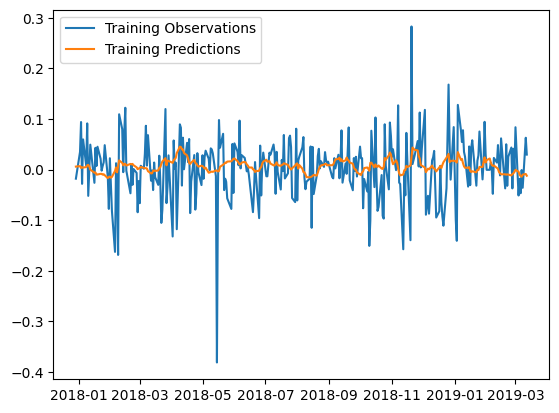

In [29]:
np.reshape(train_predictions, np.shape(dates_train))
plt.plot(dates_train, y1_train)
plt.plot(dates_train, train_predictions)
plt.legend(['Training Observations', 'Training Predictions'])

2/2 [==============================] - 0s 15ms/step


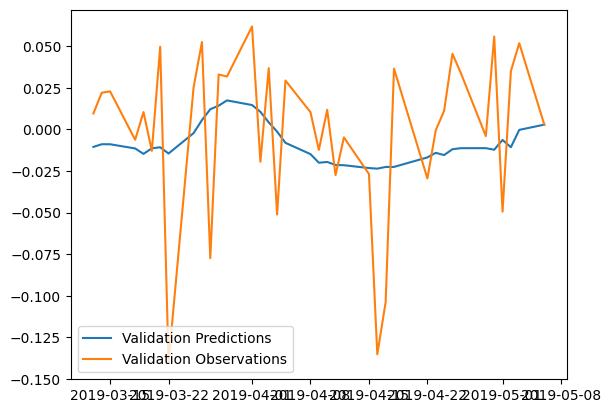

In [30]:
val_predictions = model.predict(scaled_Xval).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, scaled_y1val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 11ms/step


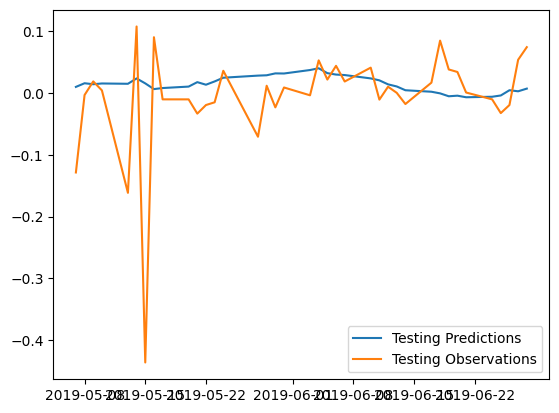

In [31]:
test_predictions = model.predict(scaled_Xtest).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, scaled_y1test)
plt.legend(['Testing Predictions', 'Testing Observations'])

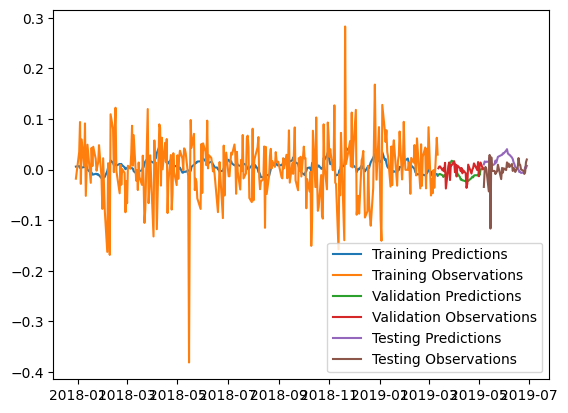

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y1_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y1_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y1_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

* Following [USMANI, S; SHAMSI, A. J; LSTM based stock prediction using weighted
and categorized financial news], a possible improvement, besides custom activation functions, varying the training & validation & testing dataset percentiles and further investigation in the number of Dense and LSTM Layers used, is compounding LSTM based stock prediction with weighted
and categorized financial news, enhancing prediction accuracy. Hyperparameters analysis is also desirable.

In [42]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
last_window = deepcopy(scaled_Xtrain[-1])
last_window.shape

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    print(next_prediction.shape)
    recursive_predictions.append(next_prediction)
    last_window = np.concatenate([last_window[1:], [next_prediction]])

1/1 [==============================] - 0s 37ms/step
(1,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5 and the array at index 1 has size 1

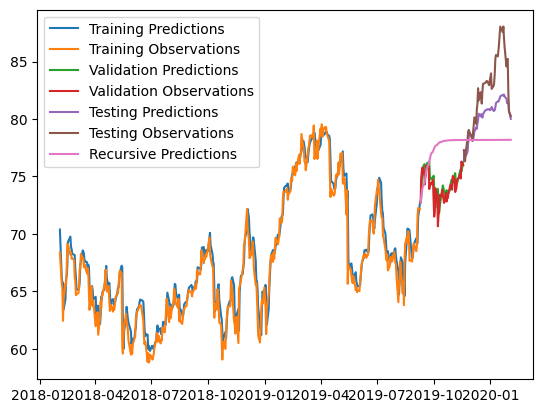

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

Simulator

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from example.lstm_strategy import lstm_strategy
from modules.strategy_simulator import strategy_simulator

# Set the path to the strategy and the strategy itself
path = "example/"  # Path to your strategy
strategy = lstm_strategy  # Your strategy

# Initialize data structures to store results
ret_port = pd.Series(dtype="float64")  # Series to store portfolio returns
weights_db = pd.DataFrame()  # DataFrame to store historical weights

# Loop through a range of time values
for t in tqdm(range(500, len(dict_data['prices'].index) - 1)):
    # Use the strategy simulator to get portfolio's historical weights [weights_db]
    # and its next day returns [ret_port]
    ret_port, weights_db = strategy_simulator(path, strategy, dict_data, t, ret_port, weights_db)
